In [66]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

TensorFlow: 2.1.0


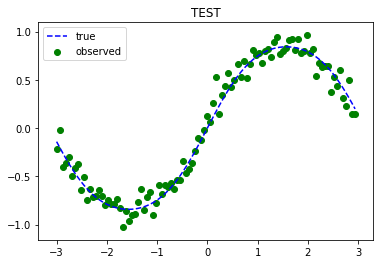

In [67]:
N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 5


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(np.sin(x))
%run Data_Generator.ipynb

In [68]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

In [69]:
class Reconfiguration_unit_steps_1_2(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps_1_2, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.scale = self.add_weight(name='scale',
                                    shape=[d+D,d+D],
                                    initializer='GlorotUniform',
                                    trainable=True)
        
    def call(self, input):
        # Relocated
        input_relocated = input + self.location
        # Rescaled
        output_steps_1_2 = tf.linalg.matvec(self.scale,input_relocated)
        # Return Ouput
        return output_steps_1_2

In [70]:
## Step 3 (Apply Bump Function)
#----------------------------#
# Define T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out
#----------------------------#
# Define Bump Function Layer
#----------------------------#
class Reconfiguration_unit_steps_3(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps_3, self).__init__(*args, **kwargs)

     
        def call(self, input):
            x_in_abs = tf.math.abs(input) < 1
            output_step_3 = tf.where(x_in_abs,bump_True(input),bump_False(input))
            return output_step_3

In [71]:
class Reconfiguration_unit_steps_4_9(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps_4_9, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.location_b = self.add_weight(name='location_b',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        
    def call(self, input):
        # 4-6. Apply Shift (In Tangent Space) and diagonalize
        x_out = tf.math.multiply(self.tangentweights,input) + self.tangentbiases
        x_out = tf.linalg.diag(x_out)
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.expm(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location_b
        
        # Return Ouput
        return output_steps_4_9

# Reconfiguration Full

In [72]:
#----------------------------#
# Define T/F Functions
#----------------------------#
def bump_True(x):
    x_out = 1- tf.math.pow(tf.math.abs(x),2)
    x_out = tf.math.exp(-tf.math.divide(1,x_out))
    return x_out

def bump_False(x):
    x_out = 0
    return x_out


In [110]:
class Reconfiguration_unit_steps(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.scale = self.add_weight(name='scale',
                                    shape=[d+D,d+D],
                                    initializer='GlorotUniform',
                                    trainable=True)
        ## Steps 4-9
        self.tangentbiases = self.add_weight(name='tangentbiases',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.tangentweights = self.add_weight(name='tangentweights',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.location_b = self.add_weight(name='location_b',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
 

    def call(self, input):
        ### Steps 1-2
        # Relocated
        input_relocated = input + self.location
        # Rescaled
        output_steps_1_2 = tf.linalg.matvec(self.scale,input_relocated)
        
        ### Step 3
        x_in_abs = tf.math.abs(output_steps_1_2) < 1
        output_step_3 = tf.where(x_in_abs,bump_True(output_steps_1_2),bump_False(output_steps_1_2))
        
        ### Step 4-9
        x_out = tf.math.multiply(self.tangentweights,output_step_3) + self.tangentbiases
        x_out = tf.linalg.diag(x_out)
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.expm(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,input)
        
        # 9. Recenter Transformed Data
        output_steps_4_9 = x_out + self.location_b
        return output_steps_4_9

In [111]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

In [118]:
# Initialize
input_layer = tf.keras.Input(shape=[d+D])
# Steps 1 and 2
current_layer  = Reconfiguration_unit_steps()(input_layer)
# Apply Reconfigurations
for i in range(N_Reconfigurations):
    current_layer = Reconfiguration_unit_steps()(current_layer)
# Map back to R^D
output_layer = projection_layer(current_layer)
NEU_OLS = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
# Summarize Model
NEU_OLS.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12        
_________________________________________________________________
reconfiguration_unit_steps_3 (None, 2)                 12 

In [119]:
NEU_OLS.compile(loss='mse',
                optimizer="SGD",
                metrics=['mae', 'mse'])

In [120]:
history = NEU_OLS.fit(
          data_NEU, NEU_targets,
          epochs=Epochs)

Train on 100 samples
Epoch 1/5
 32/100 [========>.....................] - ETA: 34s - loss: 18.1310 - mae: 4.2237 - mse: 18.1310

InvalidArgumentError:  Input matrix is not invertible.
	 [[node model_14/reconfiguration_unit_steps_33/matrix_exponential/MatrixSolve (defined at <ipython-input-110-cafb4a59012e>:46) ]] [Op:__inference_distributed_function_84410]

Function call stack:
distributed_function


In [ ]:
# Projection
NEU_prediction = NEU_OLS.predict(data_NEU)
np.shape(NEU_prediction)

In [ ]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')